In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [4]:
df.shape

(144, 2)

In [5]:
df.dtypes

Month          object
#Passengers     int64
dtype: object

In [6]:
df.columns = ['Time Frame', 'Passengers'] 

In [7]:
# converting dtype object to date
df['Time Frame'] = pd.to_datetime(df['Time Frame'])

In [8]:
df.dtypes

Time Frame    datetime64[ns]
Passengers             int64
dtype: object

In [9]:
df.set_index('Time Frame', inplace=True)
df.head()

,Passengers
Time Frame,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [10]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [11]:
df.skew()

Passengers    0.58316
dtype: float64

In [12]:
df.kurt()

Passengers   -0.364942
dtype: float64

<AxesSubplot:xlabel='Time Frame'>

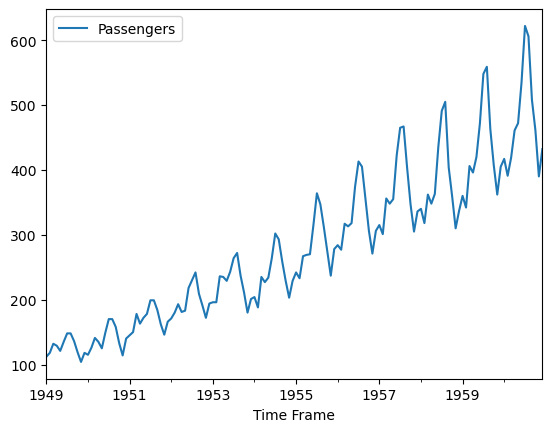

In [13]:
df.plot()

To know it is Stationery or non-stationery we will use hypothesis testing

- ho - The data is non-stationery
- h1 - The data is stationery

In [14]:
A_df = adfuller(df['Passengers'])

In [15]:
A_df

(0.8153688792060502,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

with p-value greater than 0.05(significance value) we accept the null hypothesis(h0). The data is non-stationery 

### Taking first order difference to make the data stationery 

In [16]:
df['Passengers_first_diff'] = df['Passengers'] - df['Passengers'].shift(1)

In [17]:
df.head()

,Passengers,Passengers_first_diff
Time Frame,,
1949-01-01,112,NaN
1949-02-01,118,6.0
1949-03-01,132,14.0
1949-04-01,129,-3.0
1949-05-01,121,-8.0


In [18]:
adf1 = adfuller(df['Passengers_first_diff'].dropna())

In [19]:
adf1

(-2.829266824170006,
 0.05421329028382468,
 12,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.5069317854084)

p-value is still greater than 0.05. So we take second order difference.

### Taking Second Order Diff

In [20]:
df['Passengers_with_second_diff'] = df['Passengers_first_diff'] - df['Passengers_first_diff'].shift(1) 

In [21]:
df.head()

,Passengers,Passengers_first_diff,Passengers_with_second_diff
Time Frame,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,6.0,NaN
1949-03-01,132,14.0,8.0
1949-04-01,129,-3.0,-17.0
1949-05-01,121,-8.0,-5.0


In [22]:
adf1 = adfuller(df['Passengers_with_second_diff']. dropna())

In [23]:
adf1

(-16.384231542468527,
 2.732891850014085e-29,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.6020417275605)

<AxesSubplot:xlabel='Time Frame'>

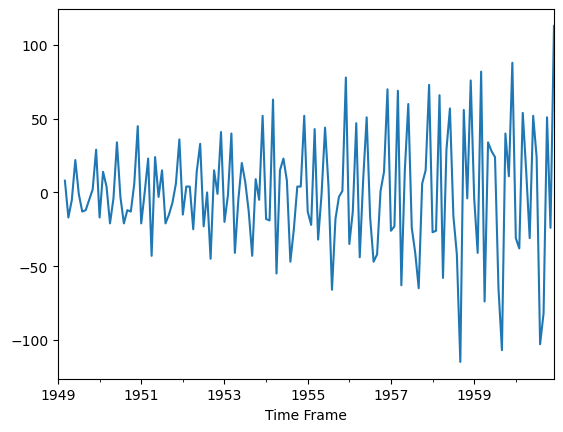

In [24]:
df['Passengers_with_second_diff'].plot()

Plotting ACF(Auto Correlation function) and P-ACF(Partial Auto Correlation function) to find the

- p-order
- Q- moving average
- D - Difference. These are the values of the ARIMA model

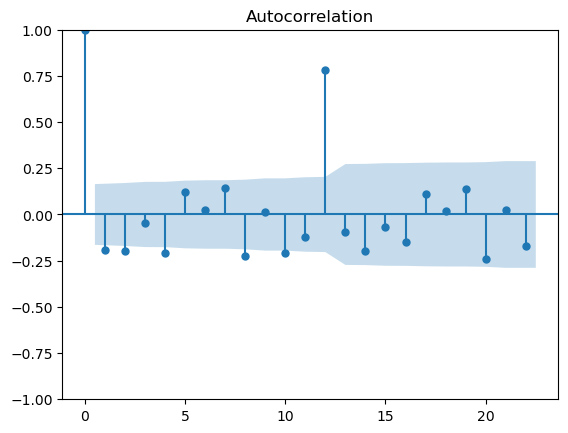

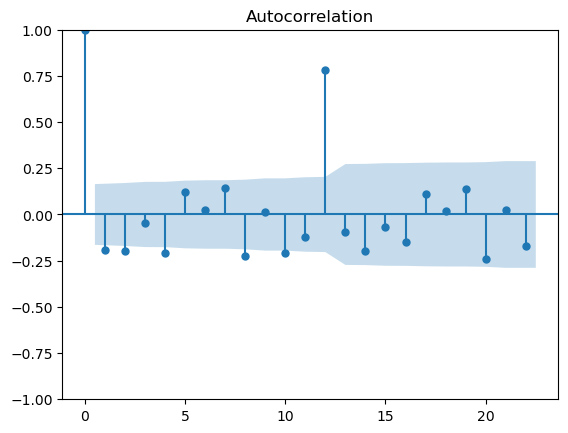

In [25]:
plot_acf(df['Passengers_with_second_diff'].dropna())

From the ACF plot we find the p-value. If we find after certain no. of lags the plot remains in the blue curve we consider those many lags as p value or the order of ARIMA model.

Here the p value is 1 

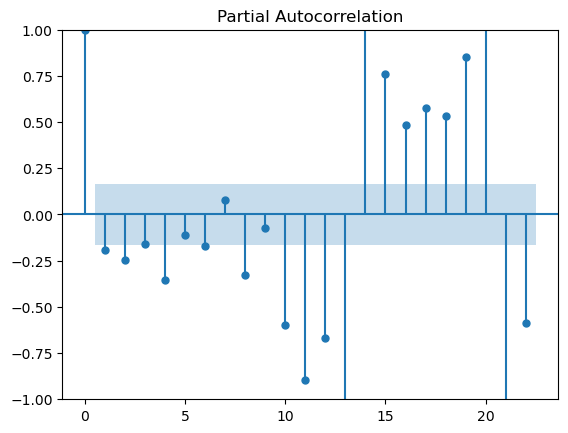

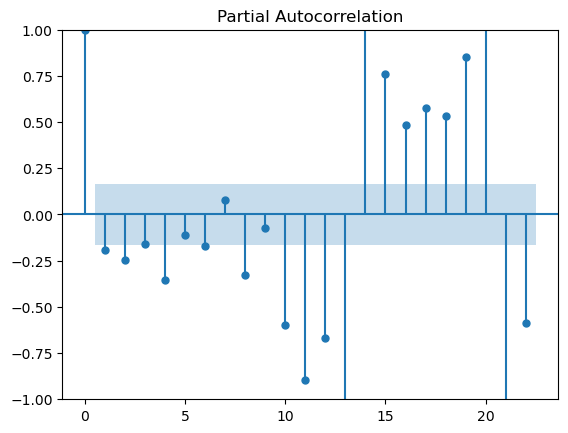

In [26]:
plot_pacf(df['Passengers_with_second_diff']. dropna())

From the P-ACF plot we find the q-value. If we find after certain no. of lags the points abruptly falls to zero we take those points as Q value to the moving average for the ARIMA model.

Here the q value is 1.

In [27]:
arima = ARIMA(df['Passengers'], order = (1,2,1))

In [28]:
arima = arima.fit()

In [29]:
df['Arima_forecast'] = arima.predict(start = 100, end = 144, dynamic=True)

<AxesSubplot:xlabel='Time Frame'>

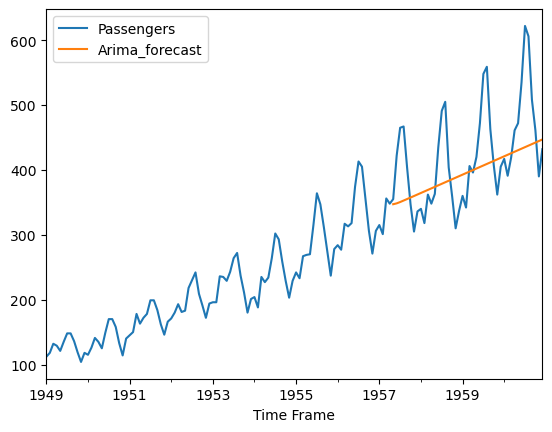

In [30]:
df[['Passengers', 'Arima_forecast']].plot()

Here we observe Arima not able to predict well as the output is not correct

### Building SARIMAX

In [31]:
seasonal_arima = SARIMAX(df['Passengers'], order = (1,2,1), seasonal_order=(1,2,1,12))

In [32]:
seasonal_arima = seasonal_arima.fit()

In [33]:
df['seasonal_arima_forecast'] = seasonal_arima.predict(start = 100, end = 144, dynamic = True)

<AxesSubplot:xlabel='Time Frame'>

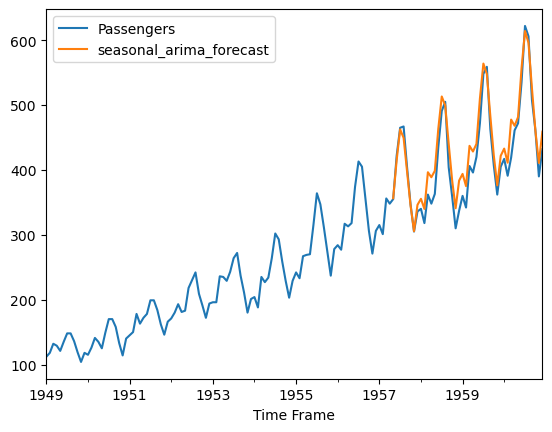

In [34]:
df[['Passengers', 'seasonal_arima_forecast']].plot()

SARIMAX is able to predict the output almost similar to the observed values.

### Predicting the future numbers

In [35]:
future_dates = [df.index[-1]+DateOffset(months = x) for x in range(0,60)]

In [36]:
future_dates

[Timestamp('1960-12-01 00:00:00'),
 Timestamp('1961-01-01 00:00:00'),
 Timestamp('1961-02-01 00:00:00'),
 Timestamp('1961-03-01 00:00:00'),
 Timestamp('1961-04-01 00:00:00'),
 Timestamp('1961-05-01 00:00:00'),
 Timestamp('1961-06-01 00:00:00'),
 Timestamp('1961-07-01 00:00:00'),
 Timestamp('1961-08-01 00:00:00'),
 Timestamp('1961-09-01 00:00:00'),
 Timestamp('1961-10-01 00:00:00'),
 Timestamp('1961-11-01 00:00:00'),
 Timestamp('1961-12-01 00:00:00'),
 Timestamp('1962-01-01 00:00:00'),
 Timestamp('1962-02-01 00:00:00'),
 Timestamp('1962-03-01 00:00:00'),
 Timestamp('1962-04-01 00:00:00'),
 Timestamp('1962-05-01 00:00:00'),
 Timestamp('1962-06-01 00:00:00'),
 Timestamp('1962-07-01 00:00:00'),
 Timestamp('1962-08-01 00:00:00'),
 Timestamp('1962-09-01 00:00:00'),
 Timestamp('1962-10-01 00:00:00'),
 Timestamp('1962-11-01 00:00:00'),
 Timestamp('1962-12-01 00:00:00'),
 Timestamp('1963-01-01 00:00:00'),
 Timestamp('1963-02-01 00:00:00'),
 Timestamp('1963-03-01 00:00:00'),
 Timestamp('1963-04-

In [37]:
df.tail()

,Passengers,Passengers_first_diff,Passengers_with_second_diff,Arima_forecast,seasonal_arima_forecast
Time Frame,,,,,
1960-08-01,606,-16.0,-103.0,437.466265,596.092075
1960-09-01,508,-98.0,-82.0,439.820837,525.909656
1960-10-01,461,-47.0,51.0,442.175409,460.313857
1960-11-01,390,-71.0,-24.0,444.529981,410.675112
1960-12-01,432,42.0,113.0,446.884554,458.962047


In [38]:
new_df = pd.DataFrame(index = future_dates[1:], columns=df.columns)

In [39]:
new_df

,Passengers,Passengers_first_diff,Passengers_with_second_diff,Arima_forecast,seasonal_arima_forecast
1961-01-01,NaN,NaN,NaN,NaN,NaN
1961-02-01,NaN,NaN,NaN,NaN,NaN
1961-03-01,NaN,NaN,NaN,NaN,NaN
1961-04-01,NaN,NaN,NaN,NaN,NaN
1961-05-01,NaN,NaN,NaN,NaN,NaN
1961-06-01,NaN,NaN,NaN,NaN,NaN
1961-07-01,NaN,NaN,NaN,NaN,NaN
1961-08-01,NaN,NaN,NaN,NaN,NaN
1961-09-01,NaN,NaN,NaN,NaN,NaN
1961-10-01,NaN,NaN,NaN,NaN,NaN


In [40]:
forecast_df = pd.concat([df, new_df])
forecast_df.head()

,Passengers,Passengers_first_diff,Passengers_with_second_diff,Arima_forecast,seasonal_arima_forecast
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,6.0,NaN,NaN,NaN
1949-03-01,132,14.0,8.0,NaN,NaN
1949-04-01,129,-3.0,-17.0,NaN,NaN
1949-05-01,121,-8.0,-5.0,NaN,NaN


In [41]:
forecast_df.tail()

,Passengers,Passengers_first_diff,Passengers_with_second_diff,Arima_forecast,seasonal_arima_forecast
1965-07-01,NaN,NaN,NaN,NaN,NaN
1965-08-01,NaN,NaN,NaN,NaN,NaN
1965-09-01,NaN,NaN,NaN,NaN,NaN
1965-10-01,NaN,NaN,NaN,NaN,NaN
1965-11-01,NaN,NaN,NaN,NaN,NaN


In [42]:
forecast_df.shape

(203, 5)

In [43]:
forecast_df['seasonal_arima_forecast'] = seasonal_arima.predict(start = 135, end =203, dynamic=True)

<AxesSubplot:>

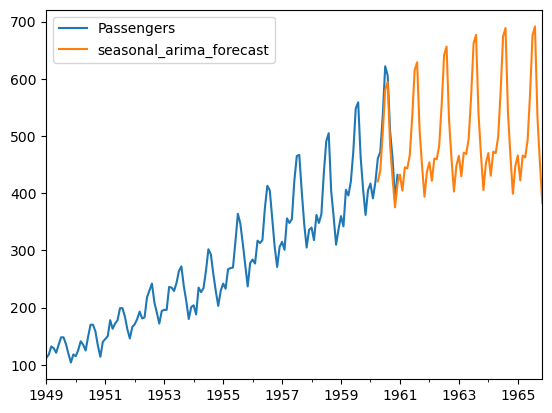

In [44]:
forecast_df[['Passengers', 'seasonal_arima_forecast']].plot()